In [5]:
import numpy as np
import pandas as pd
#import networkx as nx
import os, gensim
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from umap import UMAP
from copy import deepcopy
from importlib import reload

from claims_topics.utils import utils
from claims_topics.resources import preprocessor as preproc
from claims_topics.services import file
from claims_topics.config import global_config as glob
from claims_topics.config import config
from pathlib import Path

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 500)

reload(glob)
reload(utils)
reload(file)
reload(config)
reload(preproc)


[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'claims_topics.resources.preprocessor' from '/home/alexv84/Documents/GitHub/invoice_topics/src/claims_topics/resources/preprocessor.py'>

## Read in data:

In [2]:
config_input = config.io['input']

df = file.CSVService(root_path=glob.UC_DATA_DIR, schema_map=config_input['schema_map']['text_cols'], **config_input['service']['CSVService']).doRead()

print(df.shape)

(405350, 42)


In [3]:
# Columns to use:
#-----------------
#col_sel = ['id_sch','invoice_item_id', 'dl_gewerk','firma', 'yylobbez', 'erartbez', 'hsp_eigen', 'hsp_prodbez', 'sartbez', 'sursbez', 'schilderung', 'de1_eks_postext']
#col_sel = ['dl_gewerk','de1_eks_postext']
col_sel = ['assigned_labels', 'invoice_text']
#col_sel = ['de1_eks_postext']

corpus = df[col_sel].drop_duplicates(subset=col_sel, keep=False)#.head(1*10**5)

print(corpus.shape)
corpus.head(10)

(306320, 2)


,assigned_labels,invoice_text
0,Sonstiges,Femacellplatten 20 mm einb...
1,Installationsarbeiten,Siliconfuge entlang dem So...
3,Trocknung,Arbeitsstunden Bock 07 .06...
4,Eternit-/Skobalit-Dach,Dachfläche mit polycarbona...
5,Fliesenarbeiten,Haftgrundlerung Bodenfläch...
6,Sonstiges,"Kunststoffsockel, RAL 7016..."
7,Sonstiges,Blindnietmutter M8 352.324
8,Eternit-/Skobalit-Dach,Alu Band PP 50 mm 50 m Typ...
9,Eternit-/Skobalit-Dach,Mendinger Mittelprofil pre...
10,Fliesenarbeiten,Wannenablage Wanneli*!ase...


### Preprocess data, encode labels, prepare input for word2vec format... 

In [37]:
# Create labels for supervised topic modeling:
target = LabelEncoder().fit_transform(corpus['assigned_labels'].tolist())   # labels

# Build corpus
X = corpus['invoice_text']
#corpus['target'] = target

# Preprocess corpus:
cleaner = preproc.clean_text(language='german', without_stopwords=['nicht', 'keine'], lemma = True, stem = False)

X_cl = cleaner.fit_transform(X)

docs = X_cl.tolist()                            # format for BertTopic
target_names = corpus['assigned_labels'].tolist()       # class labels

corpus_cl = X_cl.apply(lambda x: word_tokenize(x))       # this format needed for word2vec training only

sentences = corpus_cl.tolist() 

Using 232 stop words.
Added 19 stopword(s).
Adding custom German stop words...
Removed 2 stopword(s).
Loading spaCy embeddings for lemmatization.
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Replacing German Umlaute.
Removing special character punctuations.
Removing short tokens.
Applying lemmatization.
Finished preprocessing.


# Word2Vec

In [82]:
# Train model
#-------------
reload(utils)

callback = utils.word2vec_callback()

sgram = 0
hsoft = 1
print(f"-- Using {'Skip-gram' if sgram else 'CBOW'} with {'hierarchical softmax' if hsoft else 'negative sampling'} --")
model = Word2Vec(sentences=sentences, vector_size=100, sg=sgram, hs=hsoft, window=5, 
                 min_count=1, workers=len(os.sched_getaffinity(0)), epochs=100,
                 compute_loss=True, callbacks=[callback])  # min_count = 1 needed otherwise infrequent tokens are not being assigned a word embedding
print("Done!")

Starting Word2Vec training loss monitoring...
-- Using CBOW with hierarchical softmax --
Loss - epoch 0: 1788284.625
Loss - epoch 10: 2114708.0
Loss - epoch 20: 2213860.0
Loss - epoch 30: 2030460.0
Loss - epoch 40: 1538552.0
Loss - epoch 50: 1487528.0
Loss - epoch 60: 1534200.0
Loss - epoch 70: 1558600.0
Loss - epoch 80: 0.0
Loss - epoch 90: 0.0
Done!


Plot training error:

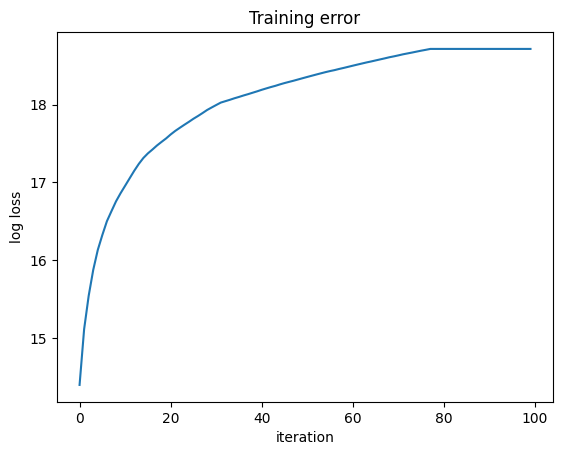

In [83]:
import matplotlib.pyplot as plt

plt.plot(np.log(callback.saved_loss_values))
plt.xlabel("iteration")
plt.ylabel("log loss")
plt.title('Training error')
plt.show();

Save model:

In [84]:
model.save(glob.UC_DATA_DIR + "/Word2Vec_embeddings.model")

Load model:

In [85]:
# Load pre-trained Word2Vec model
#model = Word2Vec.load(glob.UC_DATA_DIR + "/Word2Vec_embeddings.model")

In [86]:
#vector = model.wv['reinigung']  # get numpy vector of a word
#sims = model.wv.most_similar('reinigung', topn=10)  # get other similar words

In [87]:
#vectors = np.asarray(model.wv.vectors)
#vectors.shape

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words=cleaner.stop_words)
X = vectorizer.fit_transform(docs)
tf_idf_vec = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out().tolist())
tf_idf_vec.head()

,abbau,abbauen,abbrechen,abbruch,abdeck,abdeckarbeit,abdecken,abdeckfolie,abdeckmaterial,abdeckung,...,zone,zubehoer,zulage,zusaetzlich,zuschlag,zuschneiden,zuschnitt,zwei,zweimal,zzgl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create document (= sentence) embeddings from word embeddings

In [104]:
reload(utils)

# Call:
embeddings, index2doc, doc2index = utils.get_document_embeddings(model, sentences, docs)            # simple
#embeddings, index2doc, doc2index = utils.get_weighted_document_embeddings(model, tf_idf_vec, sentences, docs)    # tf-idf weighted

print(embeddings.shape)

100%|██████████| 306320/306320 [00:15<00:00, 19256.32it/s]

(306320, 100)


Instantiate HDBSCAN:

In [105]:
from hdbscan import HDBSCAN

cluster_model = HDBSCAN(min_cluster_size=15, cluster_selection_method='eom', prediction_data=True)

## Build topic model based on trained document embeddings:

Semi-supervised

In [106]:
new_labels = target.copy()
ind = np.array(target_names) == 'Sonstiges'   # keep out this category (unsupervised set of observations!)
new_labels[ind] = -1           # ignore
new_labels = new_labels.tolist()

Use transfer learning:

In [107]:
# from sentence_transformers import SentenceTransformer

# nr_topics = 10
# sentence_model = SentenceTransformer("deepset/gbert-base", device="cuda")

# topic_model = BERTopic(verbose=True, language="german", embedding_model=sentence_model,    
#                        vectorizer_model = vectorizer, nr_topics=nr_topics,
#                        diversity=None)

#?BERTopic

Use own embeddings:

In [108]:
from bertopic import BERTopic

os.environ["TOKENIZERS_PARALLELISM"] = "false"

nr_topics = 6     # number of clusters
#nr_topics = "auto"

topic_model = BERTopic(verbose=True, nr_topics=nr_topics, hdbscan_model=cluster_model, umap_model=None, diversity = 0.3)   # Maximal Marginal Relevance -> diversity = 0 / Not diverse
#topics, _ = topic_model.fit_transform(docs, embeddings = embeddings)                  # unsupervised  
#topics, _ = topic_model.fit_transform(docs, embeddings = embeddings, y=target)         # supervised
topics, _ = topic_model.fit_transform(docs, embeddings = embeddings, y=new_labels)         # semi-supervised

2022-11-18 22:45:15,678 - BERTopic - Reduced dimensionality
2022-11-18 22:45:40,603 - BERTopic - Clustered reduced embeddings
2022-11-18 22:48:23,595 - BERTopic - Reduced number of topics from 3379 to 7


In [109]:
df_new = pd.DataFrame({'Text': docs})
df_new['Cluster'] = topics
df_new

,Text,Cluster
0,Femacellplatt einbauen,-1
1,Siliconfug entlang Sockel,-1
2,arbeitsstund Bock,-1
3,dachflaech Polycarbonat Tr...,-1
4,Haftgrundlerung bodenflaec...,-1
...,...,...
306315,geberit Silent Abzweig Grad,0
306316,Raum wandtrocknung Standar...,-1
306317,wasserschaden betroffen An...,-1
306318,Geruestkoste einruest wint...,-1


In [110]:
#topic_model.save(os.path.join(glob.UC_DATA_ROOT,"invoice_topic_model"))     # save
#topic_model = BERTopic.load(os.path.join(glob.UC_DATA_ROOT,"invoice_topic_model"))   # load

In [111]:
# Merge cluster assignments to orginal corpus:
#corpus['topic'] = topics
#corpus.merge(topic_model.get_topic_info()[['Topic', 'Name']], how="left", left_on='topic', right_on='Topic')

In [112]:
#topic_model.get_topic_info().head(10)

Create more intuitive topic labels:

In [113]:
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")
#topic_labels

In [114]:
topic_model.set_topic_labels(topic_labels)

In [115]:
#topic_model.visualize_topics()
#topic_model.get_topic(0)
#topic_model.visualize_hierarchy(top_n_topics=50)
#topic_model.visualize_heatmap(n_clusters=nr_topics-1, width=1000, height=1000)

In [116]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
#reduced_embeddings = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

#fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

#fig.write_html(os.path.join(glob.UC_DATA_ROOT, "doc_chart.html"))    # save as html

In [117]:
fig = topic_model.visualize_barchart(n_words=10, top_n_topics=nr_topics , width=400, height=350)    # plotly figure object
fig

In [118]:
fig.write_html(os.path.join(glob.UC_DATA_PKG_DIR, "topic_barchart2.html"))    # save as html

In [36]:
#np.any(np.isnan(doc_vectors))
#np.all(np.isfinite(doc_vectors))

### Train UMAP for document embedding visualization:

In [66]:
embedding_umap = UMAP(n_components=2).fit(embeddings)

umap_embeddings = embedding_umap.embedding_

KeyboardInterrupt: 

In [ ]:
umap_embeddings.shape

(306320, 2)

Visualize compressed document embeddings in 2D

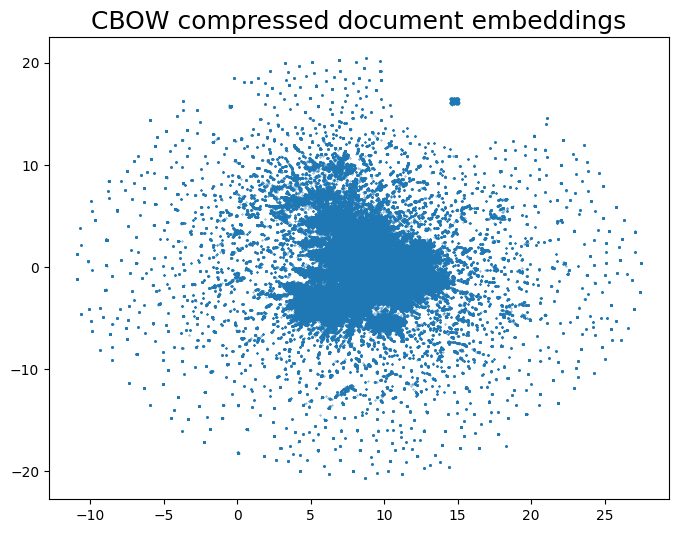

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    umap_embeddings[:, 0], umap_embeddings[:, 1], cmap="Spectral", s=0.1
)
plt.title("CBOW compressed document embeddings", fontsize=18)

plt.show();

In [1]:
#X = embeddings.copy()
#X = embeddings[:10**3,:]  # for test